In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_resnet18(pretrained=True, fine_tune=False):
    model = models.resnet18(pretrained=pretrained)

   
    for param in model.parameters():
        param.requires_grad = fine_tune

    
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 10)
    return model.to(device)


In [5]:
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, lbls in tqdm(dataloader):
            images = images.to(device)
            lbls = lbls.to(device)
            
            x = model.conv1(images)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)

            features.append(x.cpu())
            labels.append(lbls.cpu())

    features = torch.cat(features)
    labels = torch.cat(labels)
    return features.numpy(), labels.numpy()


In [6]:
def plot_embedding(features, labels, reducer, title):
    reduced = reducer.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Digits", loc='best', fontsize='small')
    plt.title(title)
    plt.tight_layout()
    plt.show()


100%|██████████| 157/157 [00:27<00:00,  5.74it/s]


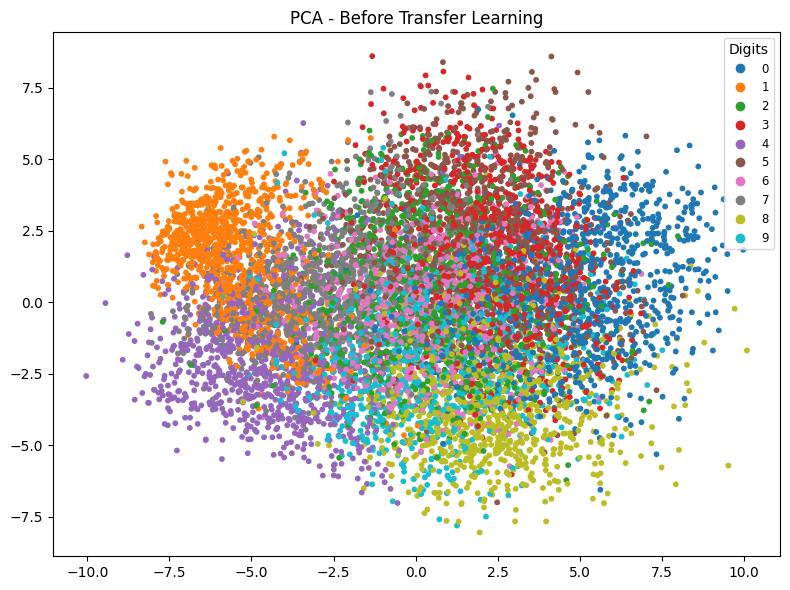

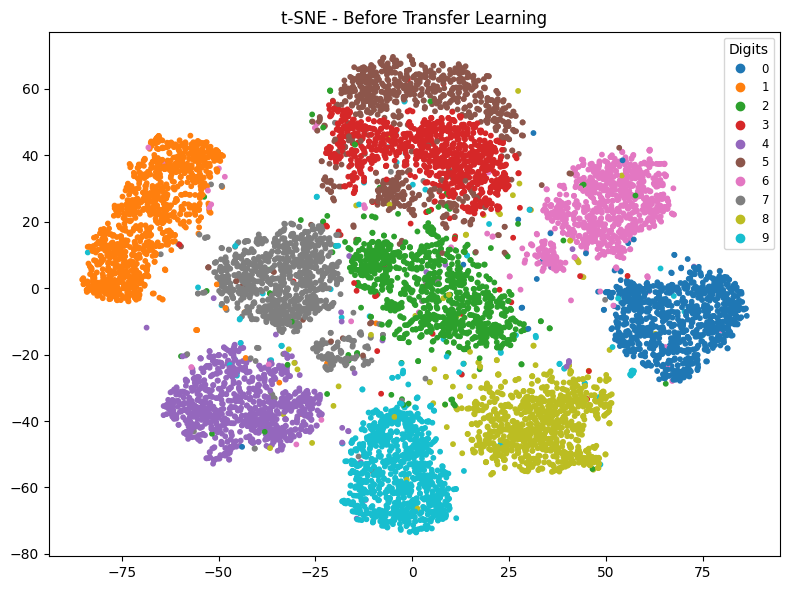

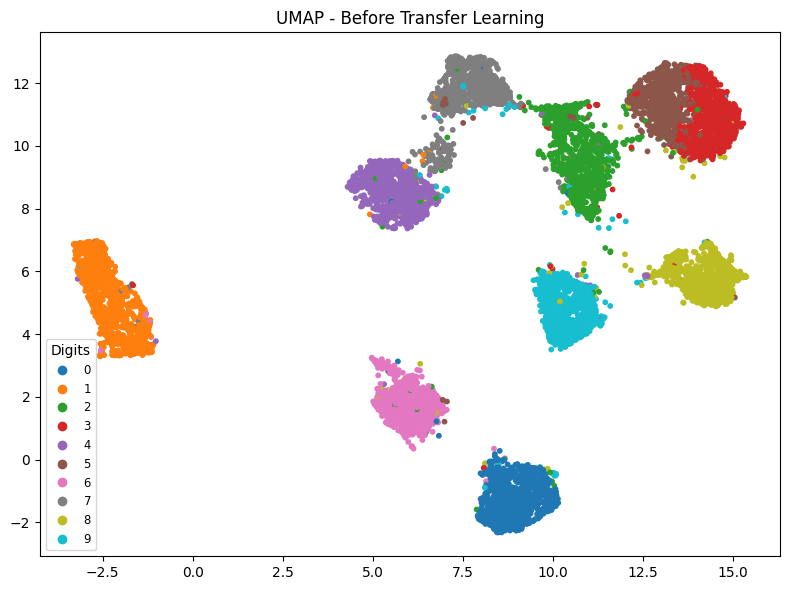

In [ ]:
model = get_resnet18(pretrained=True, fine_tune=False)
features, labels = extract_features(model, testloader)


plot_embedding(features, labels, PCA(n_components=2), "PCA - Before Transfer Learning")
plot_embedding(features, labels, TSNE(n_components=2, random_state=42), "t-SNE - Before Transfer Learning")
plot_embedding(features, labels, umap.UMAP(n_components=2, random_state=42), "UMAP - Before Transfer Learning")


In [ ]:
model = get_resnet18(pretrained=True, fine_tune=True)


for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(2):  
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [ ]:
model = get_resnet18(pretrained=True, fine_tune=True)


for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(2):  
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


100%|██████████| 157/157 [00:27<00:00,  5.61it/s]


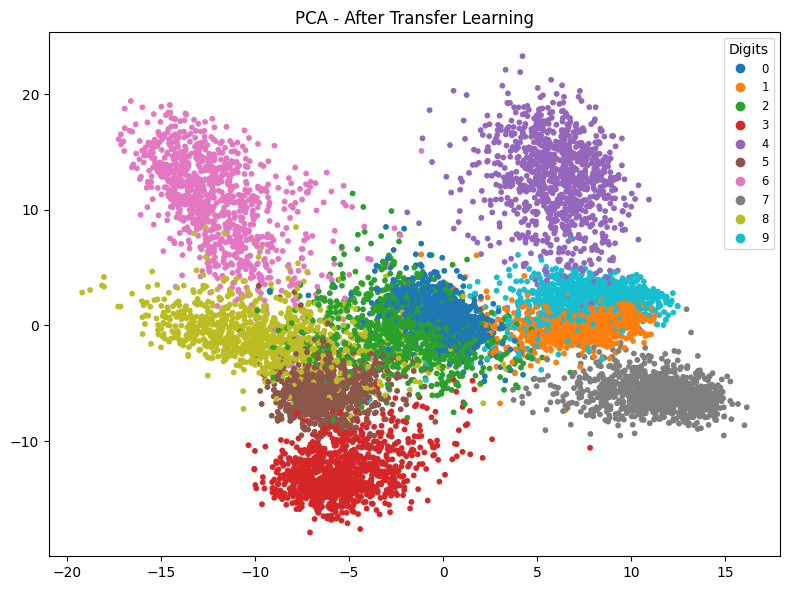

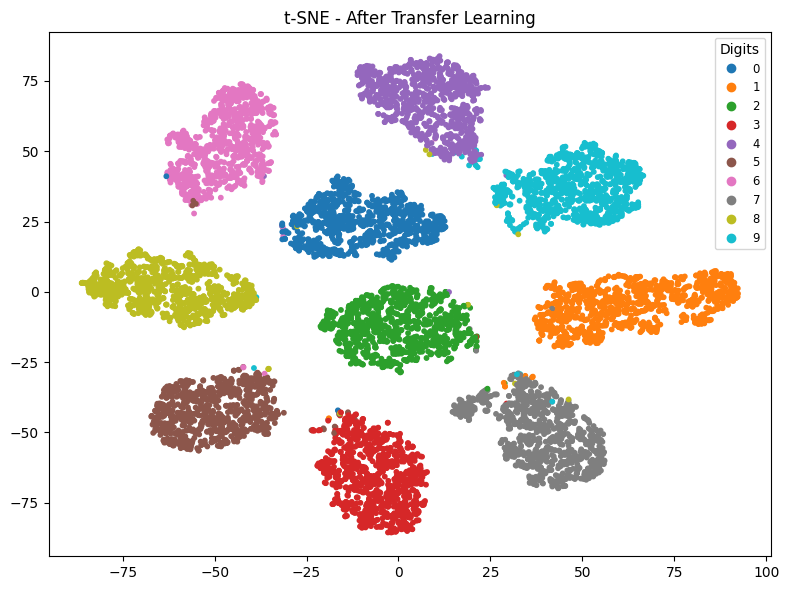

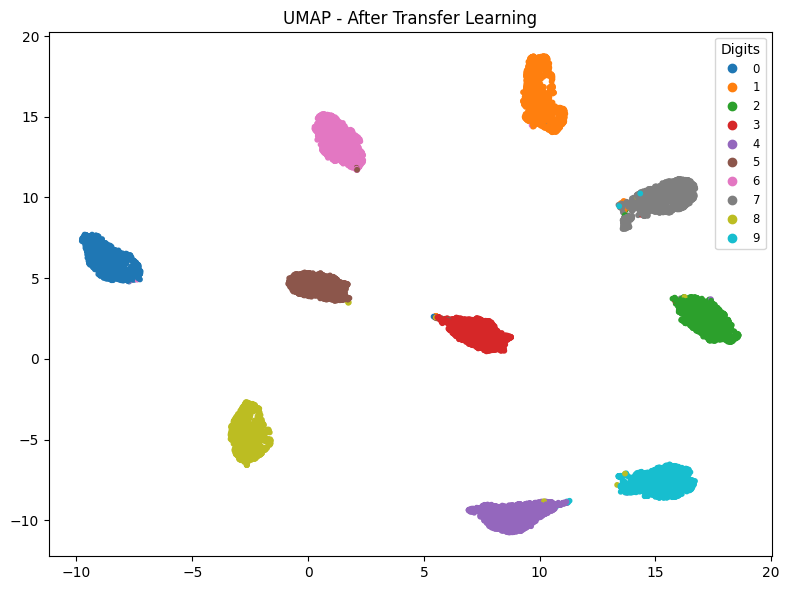

In [ ]:
features_ft, labels_ft = extract_features(model, testloader)


plot_embedding(features_ft, labels_ft, PCA(n_components=2), "PCA - After Transfer Learning")
plot_embedding(features_ft, labels_ft, TSNE(n_components=2, random_state=42), "t-SNE - After Transfer Learning")
plot_embedding(features_ft, labels_ft, umap.UMAP(n_components=2, random_state=42), "UMAP - After Transfer Learning")
